In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
% cd drive/MyDrive/DLVC-Workshop/

/content/drive/MyDrive/DLVC-Workshop
Already up to date.


In [3]:
import time

import torch
import torch.nn as nn
import numpy as np
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
name = ""

assert len(name) != 0

# Data Loading

In [2]:
from dlvc.datasets.cifar import Cifar10
from dlvc.dataset import Subset
import dlvc.ops as ops
from dlvc.batches import BatchGenerator

DATA_PATH = "./cifar-10-batches-py/"
train_data = Cifar10(DATA_PATH, Subset.TRAINING)
val_data = Cifar10(DATA_PATH, Subset.VALIDATION)
test_data = Cifar10(DATA_PATH, Subset.TEST)

In [ ]:
op = ops.chain([
    ops.type_cast(np.float32),
    ops.add(-127.5),
    ops.mul(1 / 127.5),
    # TO-DO: Add Image Augmentation
    # ops.rcrop(35, 5, 'edge'),
    # ops.add_noise(),
    # ops.rotate_image(),
    # ops.hflip(),
    ops.hwc2chw()
])

# TO-DO: Define Mini-Batch Size
BATCH_SIZE = 1

train_batches = BatchGenerator(train_data, BATCH_SIZE, False, op)
val_batches = BatchGenerator(val_data, BATCH_SIZE, False, op)
test_batches = BatchGenerator(test_data, BATCH_SIZE, False, op)

# Network Definition

In [4]:
class MyNet(nn.Module):
    def __init__(self, img_size, num_classes):
        super(MyNet, self).__init__()
        self.img_size = img_size

        # TO-DO: Create Network
        
    def forward(self, x):
        # TO-DO: Define Network Structure

        return x

In [7]:
img_shape = train_data.image_shape()
num_classes = train_data.num_classes()

net = MyNet(img_shape, num_classes).cuda()
net

In [9]:
# load the loss function from PyTorch
criterion = nn.CrossEntropyLoss()


# TO-TO: Change Optimizer: https://pytorch.org/docs/stable/optim.html
# Define Parameters: 
learning_rate = 0.01
weight_decay = 0

optimizer = torch.optim.SGD(
            net.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay, 
            nesterov=True, 
            momentum=0.9)


def get_prediction(row):             
    return np.argmax(row)

# Training

In [17]:
MAX_TIME = 600 # 10 min

train_accuracies = []
val_accuracies = []

best_acc = 0

epoch = 0
start = time.time()
while time.time()-start < MAX_TIME:
    epoch += 1
    print("Epoch #{}".format(epoch))
    num_predictions = 0
    num_correct_predictions = 0

    net.train()
    for batch in train_batches:
        data = batch.data
        labels = batch.label
        inputs = torch.from_numpy(data).cuda()
        label = torch.from_numpy(labels).long().cuda()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        predictions = np.apply_along_axis(get_prediction, 1, outputs.cpu().detach().numpy())
        correct_predictions = np.sum(predictions == labels)
        num_correct_predictions += correct_predictions
        num_predictions += len(predictions)
    print("Training Accurcay >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))
    train_accuracies.append(num_correct_predictions/num_predictions)
    
    # Validation during training
    num_predictions = 0
    num_correct_predictions = 0

    net.eval()
    with torch.no_grad():
        for val_batch in val_batches:
            data = val_batch.data
            labels = val_batch.label

            inputs = torch.from_numpy(data).cuda()

            outputs = net(inputs)
            predictions = np.apply_along_axis(get_prediction, 1, outputs.cpu().detach())
            correct_predictions = np.sum(predictions == labels)
            num_correct_predictions += correct_predictions
            num_predictions += len(predictions)
        if num_correct_predictions/num_predictions > best_acc:
            torch.save(augmented_net.state_dict(), "{}_Net.pt".format(i, round(100*num_correct_predictions/num_predictions)))
            best_acc = num_correct_predictions/num_predictions

    print("Validation Accurcay >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))
    val_accuracies.append(num_correct_predictions/num_predictions)

Epoch #1
Training Accurcay >>> 15.16%
Validation Accurcay >>> 22.94%
Epoch #2
Training Accurcay >>> 36.22%
Validation Accurcay >>> 44.78%
Epoch #3
Training Accurcay >>> 48.84%
Validation Accurcay >>> 51.87%
Epoch #4
Training Accurcay >>> 56.42%
Validation Accurcay >>> 57.4%
Epoch #5
Training Accurcay >>> 61.26%
Validation Accurcay >>> 61.45%
Epoch #6
Training Accurcay >>> 64.99%
Validation Accurcay >>> 63.73%
Epoch #7
Training Accurcay >>> 67.22%
Validation Accurcay >>> 64.81%
Epoch #8
Training Accurcay >>> 69.22%
Validation Accurcay >>> 68.17%
Epoch #9
Training Accurcay >>> 70.92%
Validation Accurcay >>> 68.62%
Epoch #10
Training Accurcay >>> 72.25%
Validation Accurcay >>> 69.72%
Epoch #11
Training Accurcay >>> 73.32%
Validation Accurcay >>> 71.44%
Epoch #12
Training Accurcay >>> 74.15%
Validation Accurcay >>> 72.43%
Epoch #13
Training Accurcay >>> 75.0%
Validation Accurcay >>> 73.13%
Epoch #14
Training Accurcay >>> 75.72%
Validation Accurcay >>> 73.65%
Epoch #15
Training Accurcay >>>

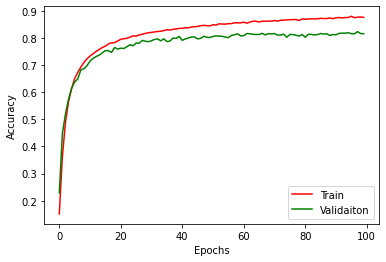

In [18]:
line1 = plt.plot(train_accuracies, color="r", label="Train")
line2 = plt.plot(val_accuracies, color="g", label="Validaiton")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Evalutation on Test Data

In [ ]:
num_predictions = 0
num_correct_predictions = 0

net.eval()
with torch.no_grad():
        for batch in test_batches:
            data = batch.data
            labels = batch.label

            inputs = torch.from_numpy(data).cuda()

            outputs = augmented_net(inputs)
            predictions = np.apply_along_axis(get_prediction, 1, outputs.cpu())
            correct_predictions = np.sum(predictions == labels)
            num_correct_predictions += correct_predictions
            num_predictions += len(predictions)
print("Validation Accurcay >>> {}%".format(round(100*num_correct_predictions/num_predictions, 2)))